In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import matplotlib as mpl

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [3]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [4]:
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
read_lens = od+expand(config['lr']['read_len_meta'], species='human')[0]

gene_subset = 'polya'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_read_lens = od+expand(config['lr']['read_len_meta'], species='mouse')[0]


In [5]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sns.set_context('paper', font_scale=2)
# plt.figure(figsize=(4,4))


## Histogram of RINs

In [22]:
df = pd.read_csv(lib_meta, sep='\t')
df2 = pd.read_csv(m_lib_meta, sep='\t')
df = pd.concat([df, df2], axis=0)
df.reset_index(drop=True, inplace=True)

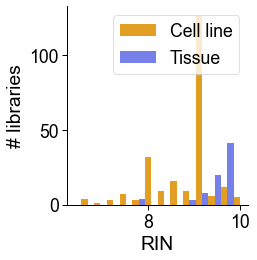

In [ ]:
# plt.figure(figsize=(4,4))
sns.set_context('paper', font_scale=2)
c_dict, order = get_tissue_cell_line_colors()
ax = sns.displot(df, kind='hist',
            hue='tissue_or_cell_line',
            x='RIN',
            multiple='dodge',
            edgecolor=None,
            palette=c_dict,
            alpha=1,
            height=4,
            aspect=1)
ax.set(ylabel='# libraries')
ax.legend.remove()
leg_labels = ['Cell line', 'Tissue']
plt.legend(leg_labels)
fname = 'figures/rin_hist_by_tissue_or_cell_line.pdf'
plt.savefig(fname, dpi=500)
plt.show()

In [26]:
# what % of RINs are >8?
df = df.loc[df.RIN.notnull()]
n_num = len(df.loc[df.RIN>=8].index)
n = len(df.index)
print(f'{(n_num/n)*100:2f}% of libraries w/ reported RINs have RIN > 8')

91.428571% of libraries w/ reported RINs have RIN > 8


## RIN vs. median read length

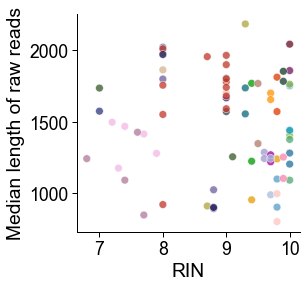

In [36]:
df = pd.read_csv(read_lens, sep='\t')
df.rename({'Unnamed: 0': 'name'}, axis=1, inplace=True)
df['ENCODE_experiment_id'] = df['name'].str.split('_', expand=True)[0]

# add sample information
meta = pd.read_csv(lib_meta, sep='\t')
meta = meta[['ENCODE_experiment_id', 'sample', 'RIN']].drop_duplicates()
df = df.merge(meta, how='left', on='ENCODE_experiment_id')
c_dict, order = get_biosample_colors(species='human')

plt.figure(figsize=(4,4))
ax = sns.scatterplot(df, x='RIN', y='read_len_median',
              hue='sample',
              palette=c_dict, s=60, alpha=0.75)
ax.get_legend().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = ax.set(ylabel='Median length of raw reads')
fname = 'figures/rin_vs_med_read_length.pdf'
plt.savefig(fname, dpi=500)

## Sequencing platforms

In [37]:
df = pd.read_csv(lib_meta, sep='\t')
df2 = pd.read_csv(m_lib_meta, sep='\t')
df = pd.concat([df, df2], axis=0)
df.reset_index(drop=True, inplace=True)

df['platform_2'] = df.platform.map({'Pacific Biosciences Sequel': 'PacBio Sequel',
                                    'Pacific Biosciences Sequel II': 'PacBio Sequel II'})

In [38]:
def get_platform_colors():
    c_dict = {'PacBio Sequel II': '#009e7f',
              'PacBio Sequel': '#6b2c75'}
    order = ['PacBio Sequel',
             'PacBio Sequel II']
    return c_dict, order

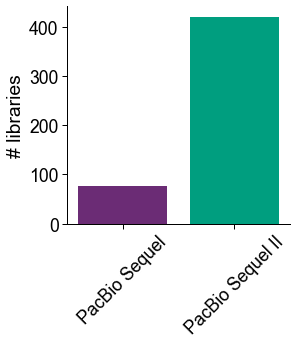

In [39]:
plt.figure(figsize=(4,4))
c_dict, order = get_platform_colors()
ax = sns.countplot(df, x='platform_2', palette=c_dict, 
              order=order, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = ax.set(ylabel='# libraries', xlabel='')
ax.tick_params(axis="x", rotation=45)
fname = 'figures/n_libraries_by_seq_plat.pdf'
plt.savefig(fname, dpi=500)

## Which spikeins does each lib have?

In [7]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sns.set_context('paper', font_scale=2)
plt.figure(figsize=(4,4))


<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

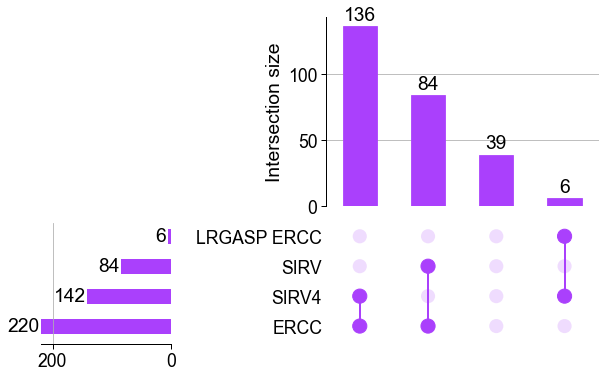

In [9]:
df = pd.read_csv(lib_meta, sep='\t')
df2 = pd.read_csv(m_lib_meta, sep='\t')
df = pd.concat([df, df2], axis=0)
df.reset_index(drop=True, inplace=True)
df['spikein_name'] = df.spikein_name.fillna('')

# get melted version
up_df = upsetplot.from_memberships(df.spikein_name.str.split(','), data=df).reset_index()
up_df = up_df.drop_duplicates()

up_df.head()
cols = ['ERCC', 'LRGASP ERCC', 'SIRV', 'SIRV4']
up_df = up_df[cols+['dataset']].set_index(cols)
upsetplot.plot(up_df, subset_size='auto',
                    show_counts='%d', sort_by='cardinality',
                    facecolor='#aa40fc', shading_color='white', element_size=None)
fname = 'figures/spikeins_per_library.pdf'
plt.savefig(fname, dpi=500)

## RT used / library

In [13]:
df = pd.read_csv(lib_meta, sep='\t')
df2 = pd.read_csv(m_lib_meta, sep='\t')
df = pd.concat([df, df2], axis=0)
df.reset_index(drop=True, inplace=True)


In [14]:
df.reverse_transcriptase.unique()

array(['Maxima H (-)', 'SuperScript IV', 'SuperScript II'], dtype=object)

In [19]:
def get_rt_colors():
    c_dict = {'Maxima H (-)': '#ea99d8',
              'SuperScript IV': '#d92d52',
              'SuperScript II': '#eecd4a'}
    order = ['Maxima H (-)',
              'SuperScript IV',
              'SuperScript II']
    return c_dict, order

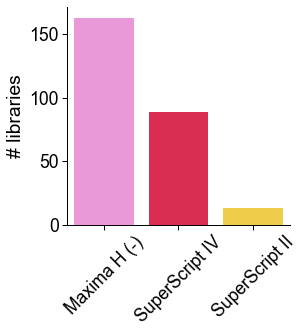

In [21]:
plt.figure(figsize=(4,4))
c_dict, order = get_rt_colors()
ax = sns.countplot(df, x='reverse_transcriptase', palette=c_dict, 
              order=order, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = ax.set(ylabel='# libraries', xlabel='')
ax.tick_params(axis="x", rotation=45)
fname = 'figures/n_libraries_by_rt.pdf'
plt.savefig(fname, dpi=500, bbox_inches='tight')